[View in Colaboratory](https://colab.research.google.com/github/sungreong/Pymc3_bayseian/blob/master/Sampler_Statistics.ipynb)

When checking for convergence or when debugging a badly behaving sampler,   
it is often helpful to take a closer look at what the sampler is doing.    
For this purpose some samplers export statistics for each generated sample.

## https://docs.pymc.io/notebooks/sampler-stats.html

In [0]:
!pip install git+https://github.com/pymc-devs/pymc3
!pip install patsy pandas

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import pymc3 as pm

%matplotlib inline

In [0]:
model = pm.Model()
with model : 
    mu1 = pm.Normal("mu1", mu=0, sd=1 ,shape=10)

In [8]:
with model : 
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000, init=None, step=step, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu1]
100%|██████████| 3000/3000 [00:06<00:00, 449.31it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


In [6]:
trace.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

* mean_tree_accept :  이 샘플을 생성 한 트리에 대한 평균 허용 확률   
                   The mean of these values across all samples but the burn-in should be approximately    
*  target_accept (the default for this is 0.8).
* diverging :  샘플에 대한 궤적이 발산하는지 여부.  만약에 많은 샘플이 발산하면, 보통 사후분포의 높은 곡률을 가진다.
*  재파리미터화는 종종 도와준다. 그러나 너는 0.9 0.95 같은 target_accept 증가시키기 위해 노력하다.
* energy  :  문제가있는 긴 꼬리가있는 후방을 식별하는 데 사용할 수 있습니다. 
* energy_error : 궤적의 시작과 끝 사이의 에너지의 차이
* tree_size :  샘플이 수락되었을 때 샘플링 트리의 잎 수 $ 2^{depth} $ 보다 적게 된다. 
> 만약 사이즈가 크다면 다음 샘플을 찾기 위하여 leapfrog steps 을 많이 사용해야 한다.  
> 사후분포 강한 상관관계를 갖는다면,  후부가 긴 꼬리가 있거나 높은 곡률의 영역 ( "깔때기")이 있거나 질량 행렬의 분산 추정치가 부정확하다.  
> Reparametrisation of the model or estimating the posterior variances from past samples might help.
* tune :  True  만약 step size 
* depth : The depth of the tree that was used to generate this sample
* tree_size : The number of leafs of the sampling tree, when the sample was accepted. This is usually a bit less than  $ 2^{depth} $
* step_size: The step size used for this sample.
* step_size_bar: The current best known step-size. After the tuning samples, the step size is set to this value. This should converge during tuning.

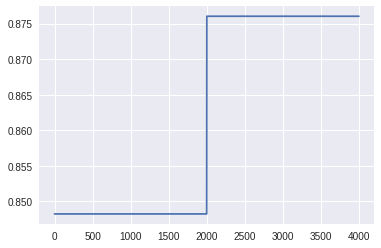

In [9]:
plt.plot(trace["step_size_bar"])

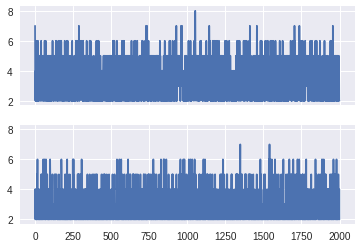

In [10]:
sizes1, sizes2 = trace.get_sampler_stats("depth", combine=False)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1.plot(sizes1)
ax2.plot(sizes2)

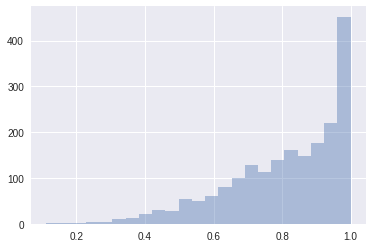

In [13]:
accept = trace.get_sampler_stats("mean_tree_accept", burn=1000)
sb.distplot(accept, kde=False)

In [14]:
accept.mean()

0.8093042004910851

In [15]:
trace["diverging"].nonzero()

(array([], dtype=int64),)

전체적인 에너지 레벨와 연속 샘플들 사이에 에너지 변화를 비교 하는데 유용하다. 

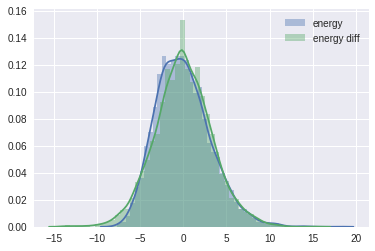

In [17]:
energy = trace["energy"]
energy_diff = np.diff(energy)
sb.distplot(energy - energy.mean(), label="energy")
sb.distplot(energy_diff , label="energy diff")
plt.legend()

## 전체적인 에너지 레벨의 분포가 긴 꼬리를 가지고 있다면  샘플러의 효율성은 매우 빨리 악화 될 것이다.

## Multiple samplers

만약 다중의 샘플러는 같은 모델에 사용됩니다(연속과 이산형 변수) 
노출 된 값은 새로운 축에 따라서 쌓이거나 합쳐진다.

In [0]:
model = pm.Model()
with model :
    mu1 = pm.Bernoulli("mu1", p=0.8)
    mu2 = pm.Normal("mu2", mu=0, sd=1, shape=10)


In [21]:
with model:
    step1 = pm.BinaryMetropolis([mu1])
    step2 = pm.Metropolis([mu2])
    trace = pm.sample(10000, init=None, step=[step1, step2], cores=2, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryMetropolis: [mu1]
>Metropolis: [mu2]
100%|██████████| 11000/11000 [00:05<00:00, 1936.18it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The number of effective samples is smaller than 10% for some parameters.


In [22]:
trace.stat_names

{'accept', 'p_jump', 'tune'}

Both samplers export accept, 그래서 우리는 각각의 샘플러 기각 확률을 얻는다.


In [24]:
trace.get_sampler_stats("accept")

array([[0.25      , 0.22052446],
       [4.        , 0.18274962],
       [0.25      , 0.00478342],
       ...,
       [0.25      , 0.1997898 ],
       [0.25      , 0.05908989],
       [1.        , 0.58121953]])

In [25]:
trace.get_sampler_stats('p_jump')

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [26]:
trace.get_sampler_stats('tune')

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])